In [1]:
import pandas as pd
import numpy as np
import stingray
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum
import datetime
from astropy.time import Time

import matplotlib.font_manager as font_manager
%matplotlib inline
# import some modules
import numpy as np
import matplotlib.pyplot as plt
import stingray
import matplotlib.ticker as ticker
from datetime import timedelta, datetime
import time
import matplotlib as mpl

# Setup a plot such that only the bottom spine is shown

# choose style of plots, `seaborn-talk` produce nice big figures
plt.style.use('seaborn-talk')

/Users/brettlv/anaconda3/lib/python3.6/site-packages/numba/core/errors.py:144: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma,xmi,yma,ymi):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi))

In [3]:
def get_namelist(df,name):
    state=df[name]
    stateori=[]
    for i in state:
        if i not in stateori:
            stateori.append(i)
    return stateori




def convert_partial_year(numbers):
    datetimes=[]
    for number in numbers:
        year = int(number)
        d = timedelta(days=(number - year)*(365 + is_leap(year)))
        day_one = datetime(year,1,1)
        date = d + day_one
        datetimes.append(date)
    return datetimes

def is_leap(year):
    if not year%4 and  year%100 or not year%400:
        return True
    return False

def convert_mjd(times):
    timesmjd=[]
    for i in times:
        timesmjd.append(Time(i).mjd)
    return timesmjd   

    

In [11]:
marker1=['*','+','x','v','^','<','>','1','2','3','4','8','p','P','h','H','X','D','d','|','_']
color1=['red','green','blue','cyan','lightblue','tan','gold','sandybrown','olivedrab','chartreuse','darkgreen','m','skyblue','violet','crimson','aqua','purple','magenta','yellow','lime','turquoise','lightcyan','teal','indigo']

# load_radio_data

In [62]:
radiomrk1018=pd.read_excel('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/multi-band-data_v20201026/Mrk1018_VLA_flux.xlsx',sheet_name='Sheet1')
radiomrk1018=radiomrk1018[radiomrk1018['rms_efficiency'].notnull()]
#radiomrk1018.columns
radiomrk1018['mjd_start']=convert_mjd(pd.to_datetime(radiomrk1018['Datestart']))
radiomrk1018['mjd_stop']=convert_mjd(pd.to_datetime(radiomrk1018['Datestop']))
radiomrk1018['meanmjd']=(radiomrk1018['mjd_stop']+radiomrk1018['mjd_start'])/2
radiomrk1018['mjderr']=(radiomrk1018['mjd_stop']-radiomrk1018['mjd_start'])/2
radiomrk1018['Ferr']=np.sqrt(radiomrk1018['Fint(mJy)']**2*radiomrk1018['rms_efficiency']**2+radiomrk1018['rms']**2)

In [51]:
radiomrk1018.columns

Index(['Datestart', 'Datestop', 'project', 'project_sure', 'band', 'frequency',
       'f_GHz', 'GHz_label', 'peak(mJy/beam)', 'alpha', 'Fint(mJy)', 'err',
       'rms', 'rescale_alpha', 'rescale_alpha_err', 'rescale_5GHz',
       'rms_efficiency', 'unit', 'proposal', 'paper', 'Note', 'mjd_start',
       'mjd_stop', 'meanmjd', 'mjderr', 'Ferr'],
      dtype='object')

# def scale data

In [63]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
import emcee
import corner
import os
from timeit import default_timer as timer

def calc_power_law(freq,S0,alpha):
    S = S0 * (freq) ** alpha
    return S

def alpha_calc(data):    
    #Get lightcurve values
    freqs = data['frequency']
    flux = data['Fint(mJy)']
    flux_errs = data['Ferr']
    
    #Use the scipy curve_fit algorithm to calculate the best fit value
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1] #Best-fit spectral index
    alpha_err = np.sqrt(np.diag(pcov))[1] #Uncertainty in alpha
    
    return alpha, alpha_err

def scale_data(data, alpha, alpha_err, ref_freq=5.0):
    #calculate a scaling factor for the flux density and uncertainty
    alpha=data['rescale_alpha'] #specify one  
    alpha_err=data['rescale_alpha_err']
    f_scale = (ref_freq/data['frequency'])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data['frequency'])*alpha_err)
    
    
    #scale the flux and uncertainty - don't forget to add errors in quadrature
    scaled_flux = data['Fint(mJy)'] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data['rms']/data['Fint(mJy)'])**2 + (rms_scale/f_scale)**2)
    
    #Add two new columns to the data
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms    
    return data

In [64]:
radiomrk1018

,Datestart,Datestop,project,project_sure,band,frequency,f_GHz,GHz_label,peak(mJy/beam),alpha,...,rms_efficiency,unit,proposal,paper,Note,mjd_start,mjd_stop,meanmjd,mjderr,Ferr
2,1984-11-28,1984-11-28,AU0020,NaN,L,1.49,1.4GHz,1.4GHz,NaN,NaN,...,0.05,NaN,vla_data_reduction,NaN,NaN,46032.0,46032.0,46032.0,0.0,0.233046
3,1984-11-28,1984-11-28,AU0020,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,0.05,NaN,vla_data_reduction,NaN,NaN,46032.0,46032.0,46032.0,0.0,0.139679
4,1988-04-10,1988-04-10,AB0476,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,0.05,NaN,vla_data_reduction,NaN,NaN,47261.0,47261.0,47261.0,0.0,0.230695
5,1989-06-15,1989-06-15,AB0540A,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,0.05,NaN,vla_data_reduction,NaN,NaN,47692.0,47692.0,47692.0,0.0,0.158937
6,1989-07-25,1989-07-25,AB0540B,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,0.05,NaN,vla_data_reduction,NaN,NaN,47732.0,47732.0,47732.0,0.0,0.173897
8,1993-12-18,1994-01-31,AC0308,NaN,L,1.40,1.4GHz,1.4GHz,NaN,NaN,...,0.05,NaN,VLANED,2002AJ....124..675C,Condon+2002,49339.0,49383.0,49361.0,22.0,0.542310
10,1995-10-23,1995-11-18,AB0628,NaN,L,1.40,1.4GHz,1.4GHz,NaN,NaN,...,0.05,NaN,NVSSVIII/65,1998AJ....115.1693C,Condon+1998,50013.0,50039.0,50026.0,13.0,0.451774
11,1998-06-06,1998-06-06,AB0878,NaN,X,8.46,8.4GHz,8.4GHz,NaN,NaN,...,0.05,NaN,vla_data_reduction,NaN,NaN,50970.0,50970.0,50970.0,0.0,0.165385
12,2002-07-19,2002-08-08,AB0950,NaN,L,1.40,1.4GHz,1.4GHz,3.340,NaN,...,0.05,mJy,FirstsurveyVIII/71(v03Apr11),2003yCat.8071....0B,Becker+2003,52474.0,52494.0,52484.0,10.0,0.252571
14,2008-12-21,2009-04-03,AR685,1.0,L,1.40,1.4GHz,1.4GHz,2.450,NaN,...,0.05,mJy,J/AJ/142/3/stripe82,2011AJ....142....3H,Hodge+2011,54821.0,54924.0,54872.5,51.5,0.192523


In [65]:
def get_namelist(df,name):
    state=df[name]
    stateori=[]
    for i in state:
        if i not in stateori:
            stateori.append(i)
    return stateori

parax='meanmjd'
paraxerr='mjderr'
paray='Fint(mJy)'
parayerr='Ferr'
parafreq='frequency'
paraband='band'
filename=radiomrk1018
radio_freqlist=get_namelist(filename,parafreq)
radio_bandlist=get_namelist(filename,paraband)

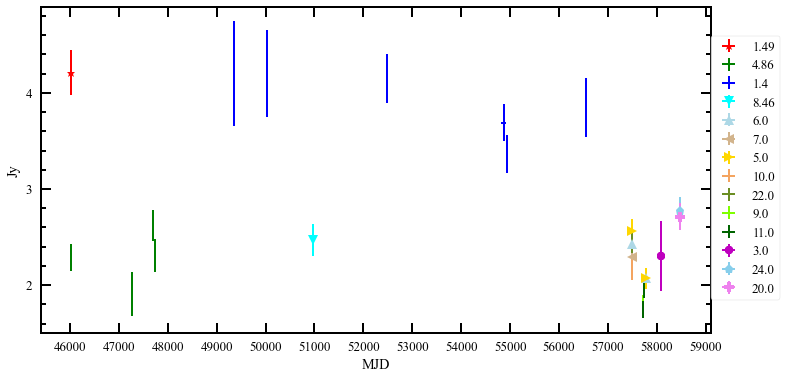

In [66]:
namelist=radio_freqlist
paralist=parafreq
marker1=['*','+','x','v','^','<','>','1','2','3','4','8','p','P','h','H','X','D','d','|','_']
color1=['red','green','blue','cyan','lightblue','tan','gold','sandybrown','olivedrab','chartreuse','darkgreen','m','skyblue','violet','crimson','aqua','purple','magenta','yellow','lime','turquoise','lightcyan','teal','indigo']

fig = plt.figure(figsize=(12, 6))
# Add axes object to our figure that takes up entire figure
#ax = fig.add_axes([0, 0, 1, 1])
ax3=fig.add_subplot(1,1,1)
for i,m,c, in zip(namelist,marker1[:len(namelist)],color1[:len(namelist)]):
    x=filename[filename[paralist]==i][parax]
    xerr=filename[filename[paralist]==i][paraxerr]
    y=filename[filename[paralist]==i][paray]
    yerr=filename[filename[paralist]==i][parayerr]
    ax3.errorbar(x,y,xerr=xerr,yerr=yerr,marker=m,color=c,label=i,fmt='o',elinewidth=2)

ax3.legend(loc=(1.0,0.1))    
set_ax_tick(ax3)
set_ax_locator(ax3,1000,2000,1.0,0.2)
ax3.set_xlabel('MJD')
ax3.set_ylabel('Jy')

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2    

In [16]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == 'AU0020']
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)','project']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

   meanmjd  frequency  Fint(mJy) project
2  46032.0       1.49       4.21  AU0020
3  46032.0       4.86       2.29  AU0020
alpha = -0.52 +/- 0.07


In [30]:
sel_data2 = radiomrk1018[radiomrk1018['meanmjd'] >50000]
sel_data2 = sel_data2[sel_data2['meanmjd'] <52000]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)','project']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy) project
10  50026.0       1.40       4.20  AB0628
11  50970.0       8.46       2.47  AB0878
alpha = -0.30 +/- 0.07


In [29]:
sel_data2 = radiomrk1018[radiomrk1018['meanmjd'] >50900]
sel_data2 = sel_data2[sel_data2['meanmjd'] <53000]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)','project']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy) project
11  50970.0       8.46       2.47  AB0878
12  52484.0       1.40       4.15  AB0950
alpha = -0.29 +/- 0.05


In [31]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16A-444']
sel_data2 = sel_data2[sel_data2['band'] == 'C']
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)','project']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)  project
23  57481.0        6.0       2.43  16A-444
24  57481.0        7.0       2.29  16A-444
25  57481.0        5.0       2.56  16A-444
alpha = -0.33 +/- 0.21


In [32]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16A-444']
sel_data2

,Datestart,Datestop,project,project_sure,band,frequency,f_GHz,GHz_label,peak(mJy/beam),alpha,...,rms_efficiency,unit,proposal,paper,Unnamed: 20,mjd_start,mjd_stop,meanmjd,mjderr,Ferr
23,2016-04-03,2016-04-03,16A-444,NaN,C,6.0,6GHz,NaN,NaN,NaN,...,0.05,NaN,NaN,NaN,NaN,57481.0,57481.0,57481.0,0.0,0.121911
24,2016-04-03,2016-04-03,16A-444,NaN,C,7.0,7GHz,NaN,NaN,NaN,...,0.05,NaN,NaN,NaN,NaN,57481.0,57481.0,57481.0,0.0,0.114936
25,2016-04-03,2016-04-03,16A-444,NaN,C,5.0,5GHz,5GHz,NaN,NaN,...,0.05,NaN,changinglookproposal,NaN,NaN,57481.0,57481.0,57481.0,0.0,0.128390
26,2016-04-03,2016-04-03,16A-444,NaN,X,10.0,10GHz,10GHz,NaN,NaN,...,0.05,NaN,changinglookproposal,NaN,NaN,57481.0,57481.0,57481.0,0.0,0.108462
29,2016-04-03,2016-04-03,16A-444,NaN,K,22.0,22GHz,20GHz,NaN,NaN,...,0.05,NaN,changinglookproposal,NaN,NaN,57481.0,57481.0,57481.0,0.0,0.123406


In [35]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16A-444']
sel_data2 = sel_data2.iloc[[2,3]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
25  57481.0        5.0       2.56
26  57481.0       10.0       2.16
alpha = -0.25 +/- 0.10


In [36]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16A-444']
sel_data2 = sel_data2.iloc[[2,4]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
25  57481.0        5.0       2.56
29  57481.0       22.0       2.46
alpha = -0.03 +/- 0.05


In [37]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16A-444']
sel_data2 = sel_data2.iloc[[2,3,4]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
25  57481.0        5.0       2.56
26  57481.0       10.0       2.16
29  57481.0       22.0       2.46
alpha = -0.02 +/- 0.05


In [38]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16B-084']
sel_data2 = sel_data2.iloc[[3,7]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
35  57731.0       10.0      1.968
39  57768.0        5.0      2.070
alpha = -0.07 +/- 0.10


In [39]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16B-084']
sel_data2 = sel_data2[sel_data2['band'] == 'X']
sel_data2 = sel_data2[sel_data2['meanmjd'] == 57719.0 ]

alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
32  57719.0       10.0       1.78
33  57719.0        9.0       1.81
34  57719.0       11.0       1.75
alpha = -0.17 +/- 0.36


In [40]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16B-084']
sel_data2 = sel_data2[sel_data2['band'] == 'X']
sel_data2 = sel_data2[sel_data2['meanmjd'] == 57731.0]

alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
35  57731.0       10.0      1.968
36  57731.0        9.0      1.972
37  57731.0       11.0      1.963
alpha = -0.02 +/- 0.35


In [41]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16B-084']
sel_data2 = sel_data2.iloc[[0,7]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
32  57719.0       10.0       1.78
39  57768.0        5.0       2.07
alpha = -0.22 +/- 0.11


In [42]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16B-084']
sel_data2 = sel_data2.iloc[[3,7]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
35  57731.0       10.0      1.968
39  57768.0        5.0      2.070
alpha = -0.07 +/- 0.10


In [43]:
sel_data2 = radiomrk1018[radiomrk1018['project'] == '16B-084']
sel_data2 = sel_data2[sel_data2['band'] == 'C']
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)
38  57768.0        6.0       2.07
39  57768.0        5.0       2.07
alpha = 0.00 +/- 0.04


In [44]:
sel_data2 = radiomrk1018[radiomrk1018['meanmjd'] >=57768]
sel_data2 = sel_data2[sel_data2['meanmjd'] <=58087]
sel_data2 = sel_data2.iloc[[1,2]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)','project']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)   project
39  57768.0        5.0       2.07   16B-084
40  58087.0        3.0       2.30  VLASS1.1
alpha = -0.21 +/- 0.32


In [45]:
sel_data2 = radiomrk1018[radiomrk1018['meanmjd'] >=58087]
sel_data2 = sel_data2[sel_data2['meanmjd'] <=58472]
sel_data2 = sel_data2.iloc[[0,2]]
alpha, alpha_err = alpha_calc(sel_data2)
print(sel_data2[['meanmjd','frequency','Fint(mJy)','project']])
print("alpha = %.2f +/- %.2f"%(alpha, alpha_err))

    meanmjd  frequency  Fint(mJy)   project
40  58087.0        3.0       2.30  VLASS1.1
42  58472.0       20.0       2.71   18B-245
alpha = 0.09 +/- 0.09


In [46]:
radiomrk1018.columns

Index(['Datestart', 'Datestop', 'project', 'project_sure', 'band', 'frequency',
       'f_GHz', 'GHz_label', 'peak(mJy/beam)', 'alpha', 'Fint(mJy)', 'err',
       'rms', 'rescale_alpha', 'rescale_alpha_err', 'rescale_5GHz',
       'rms_efficiency', 'unit', 'proposal', 'paper', 'Unnamed: 20',
       'mjd_start', 'mjd_stop', 'meanmjd', 'mjderr', 'Ferr'],
      dtype='object')

# export data

In [67]:
radiomrk1018['C_alpha']=-1*radiomrk1018['rescale_alpha']
radiomrk1018.to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/multi-band-data_v20201026/Mrk1018radio_data.csv')

radiomrk1018

In [68]:
scaleddata_5GHz=radiomrk1018[radiomrk1018['rescale_5GHz'] == 1]
scaleddata=scale_data(scaleddata_5GHz,alpha=0, alpha_err=0.1, ref_freq=5.0)
scaleddata.to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/multi-band-data_v20201026/Mrk1018radiolc_rescale.csv')

/Users/brettlv/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/brettlv/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [69]:
scaleddata

,Datestart,Datestop,project,project_sure,band,frequency,f_GHz,GHz_label,peak(mJy/beam),alpha,...,paper,Note,mjd_start,mjd_stop,meanmjd,mjderr,Ferr,C_alpha,scaled_flux,scaled_rms
3,1984-11-28,1984-11-28,AU0020,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,NaN,NaN,46032.0,46032.0,46032.0,0.0,0.139679,0.52,2.256430,0.078955
4,1988-04-10,1988-04-10,AB0476,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,NaN,NaN,47261.0,47261.0,47261.0,0.0,0.230695,0.30,1.893796,0.208252
5,1989-06-15,1989-06-15,AB0540A,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,NaN,NaN,47692.0,47692.0,47692.0,0.0,0.158937,0.30,2.597773,0.089386
6,1989-07-25,1989-07-25,AB0540B,NaN,C,4.86,4.8GHz,5GHz,NaN,NaN,...,NaN,NaN,47732.0,47732.0,47732.0,0.0,0.173897,0.30,2.290403,0.128978
8,1993-12-18,1994-01-31,AC0308,NaN,L,1.40,1.4GHz,1.4GHz,NaN,NaN,...,2002AJ....124..675C,Condon+2002,49339.0,49383.0,49361.0,22.0,0.542310,0.30,2.866795,0.449120
10,1995-10-23,1995-11-18,AB0628,NaN,L,1.40,1.4GHz,1.4GHz,NaN,NaN,...,1998AJ....115.1693C,Condon+1998,50013.0,50039.0,50026.0,13.0,0.451774,0.30,2.866795,0.399721
11,1998-06-06,1998-06-06,AB0878,NaN,X,8.46,8.4GHz,8.4GHz,NaN,NaN,...,NaN,NaN,50970.0,50970.0,50970.0,0.0,0.165385,0.30,2.892125,0.177187
12,2002-07-19,2002-08-08,AB0950,NaN,L,1.40,1.4GHz,1.4GHz,3.340,NaN,...,2003yCat.8071....0B,Becker+2003,52474.0,52494.0,52484.0,10.0,0.252571,0.30,2.832667,0.304756
14,2008-12-21,2009-04-03,AR685,1.0,L,1.40,1.4GHz,1.4GHz,2.450,NaN,...,2011AJ....142....3H,Hodge+2011,54821.0,54924.0,54872.5,51.5,0.192523,0.30,2.518685,0.259229
17,2009-04-05,2009-04-05,AB1314,1.0,L,1.40,1.4GHz,1.4GHz,2.960,NaN,...,2015ApJ…801..26H,Helfand+2015,54926.0,54926.0,54926.0,0.0,0.196023,0.30,2.293436,0.243519


In [8]:
#radiomrk1018_export=(radiomrk1018.loc[:, ['project','frequency','meanmjd', 'mjderr','band','Fint(mJy)','Ferr']].sort_values('meanmjd'))
#radiomrk1018_export=radiomrk1018_export.reset_index(drop=True)
#radiomrk1018_export.to_csv('/Users/brettlv/blog/IHEP_sync/paper/dataMrk1018/Mrk1018radio.csv')

In [ ]:


filename=radiomrk1018
parax='meanepoch'
paraxerr='terr'
parax1='Datestart'
parax2='Datestop'
paray='Fint(mJy)'
parayerr='rms'
paralist='band'

t1=np.array(pd.to_datetime(filename[parax1]),dtype='datetime64[D]')
t2=np.array(pd.to_datetime(filename[parax2]),dtype='datetime64[D]')

tmean=t1+(t2-t1)/2
terr=(t2-t1)/2

filename['meanepoch']=tmean
filename['terr']=terr
namelist=['L', 'C', 'X', 'K',]
#print(namelist)
namelistall=get_namelist(filename,paralist)
print(len(namelistall))
print(namelistall)